# IMPORTs

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import glob
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import random
import torchvision.transforms.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('using device:', device)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

# FUNCTIONS

In [ ]:
def save_model(model, history, model_path, history_path):
    # Save the model state dict
    torch.save(model, model_path)

    save_history_to_csv(history, history_path)

    print(f"Model saved to {model_path}")
    print(f"History saved to {history_path}")

def save_history_to_csv(history, filename):
    df = pd.DataFrame(history)
    df.to_csv(filename, index=False)
    print(f"History saved to {filename}")
    
def load_entire_model(model_path, device):
    # Load the entire model
    model = torch.load(model_path, weights_only=False)
    model.to(device)  # Ensure the model is on the correct device (CPU or GPU)
    print(f"Model loaded from {model_path}")
    
    return model


def plot_history_unet(df, max_epochs):
    # Filter the DataFrame to include only the epochs up to max_epochs
    if isinstance(df['epoch'], range):
        # 'epoch' is a column in the DataFrame
        epochs = list(df['epoch'])[:max_epochs]
        train_losses = df['train_loss'][:max_epochs]
        val_losses = df['val_loss'][:max_epochs]
        train_ious = df['train_iou'][:max_epochs]
        val_ious = df['val_iou'][:max_epochs]
    else:
        # 'epoch' is a range object
        df_filtered = df[df['epoch'] <= max_epochs]
        epochs = df_filtered['epoch']
        train_losses = df_filtered['train_loss']
        val_losses = df_filtered['val_loss']
        train_ious = df_filtered['train_iou']
        val_ious = df_filtered['val_iou']


    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)  # Add grid

    # Plot IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_ious, label='Training IoU', color='blue', marker='o')
    plt.plot(epochs, val_ious, label='Validation IoU', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('Training and Validation IoU')
    plt.legend()
    plt.grid(True)  # Add grid

    plt.tight_layout()
    plt.show()

def train_model_unet(model, dataloader, val_dataloader, optimizer, criterion, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    
    # scheduler = StepLR(optimizer, step_size=5, gamma=0.1) # not applied in current training

    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_iou = 0.0  # IoU accumulator for training

        lr = optimizer.param_groups[0]['lr']

            
        # Create a tqdm progress bar for the dataloader
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs} lr = {lr}", ncols=100, unit="batch")

        for batch in progress_bar:
            # Access image and mask from the batch (batch is a tuple)
            inputs, labels = batch  # Unpack the tuple into inputs and labels
            # labels = labels.squeeze(2) 
            # Move the tensors to the appropriate device (e.g., GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Make predictions by passing the inputs through the model
            optimizer.zero_grad()  # Clear gradients from the previous step
            outputs = model(inputs)  # Pass inputs through the model
            loss = criterion(outputs, labels)  # Calculate loss

            # Backward pass: Compute gradients and update model weights
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update weights using optimizer

            # Accumulate loss and IoU for this batch
            running_loss += loss.item()
            outputs = outputs.detach().cpu().numpy()  # Detach outputs and move to CPU
            labels = labels.detach().cpu().numpy()  # Detach labels and move to CPU
            iou = compute_iou(outputs, labels)  # IoU calculation
            running_iou += iou

        # Calculate training loss and IoU for the current epoch
        train_loss = running_loss / len(dataloader)
        train_iou = running_iou / len(dataloader)

        # Evaluate the model on the validation set
        val_loss, val_iou = evaluate_model_unet(model, val_dataloader, criterion, device)

        # Save metrics for this epoch
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        # Print metrics for this epoch
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss={train_loss:.4f}, Train IoU={train_iou:.4f}, "
              f"Val Loss={val_loss:.4f}, Val IoU={val_iou:.4f}")

        # scheduler.step()  
    # Return the history for further processing (such as saving or plotting)
    history = {
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }

    return history  # Return the history dictionary



def compute_iou(preds, labels, threshold=0.5, num_classes=2):
    # preds are probabilities (not logits), threshold them to get binary masks
    preds = (preds > threshold).astype(int)  # Binary thresholding
    
    ious = []
    for i in range(num_classes):  # For each class (0 and 1 for binary segmentation)
        intersection = np.sum((preds == i) & (labels == i))
        union = np.sum((preds == i) | (labels == i))
        iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou)

    return np.mean(ious)

@torch.no_grad()
def evaluate_model_unet(model, val_dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    running_iou = 0.0  # IoU accumulator for validation
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients for validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()

            # For binary segmentation, apply sigmoid and threshold to get binary predictions
            preds = (outputs > 0.5).cpu().numpy()  # Apply threshold for binary classification
            
            # Compute IoU for this batch
            iou = compute_iou(preds, labels.cpu().numpy())
            running_iou += iou

            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    # Calculate mean IoU for the entire validation set
    mean_iou = running_iou / len(val_dataloader)

    # Return the validation loss and mean IoU
    return val_loss / len(val_dataloader), mean_iou

def load_history_from_csv(filename):
    df = pd.read_csv(filename)
    return df


# U NET

**INITIATE DATASET (AUGMENTED)**

In [5]:


# HYPERPARAMETERS
SIZE_X, SIZE_Y = 224, 224
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
EPOCHS = 20

image_transform = transforms.Compose([
    transforms.Resize((SIZE_X, SIZE_Y), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),  # Convert to tensor (H, W, C) -> (C, H, W)
    transforms.Normalize([0.485, 0.456, 0.406], [.229, .224, .225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((SIZE_X, SIZE_Y), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),  # Convert mask to tensor
])

def augment_image_and_mask(image, mask, p=0.5):
    # Random Horizontal Flip
    if random.random() < p:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)

    # Random Rotation (0-30 degrees in either direction)
    if random.random() < p:
        angle = random.uniform(-30, 30)  # Rotate between -30 to +30 degrees
        image = transforms.functional.rotate(image, angle)
        mask = transforms.functional.rotate(mask, angle)

    # Apply Color Jitter
    if random.random() < p:
        jitter = transforms.ColorJitter(brightness=0.2, contrast=1)
        image = jitter(image)

    return image, mask


# Dataset Paths
image_dir = "./DATASET/TRAIN_UNET/enhanced_images - ESRGAN"
mask_dir = "./DATASET/TRAIN_UNET/mask"

# Get sorted list of images and masks
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

assert len(image_paths) == len(mask_paths), "Mismatch in image-mask pairs!"

# Split Dataset (80% train, 10% val, 10% test)
total_size = len(image_paths)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure full dataset is used

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size+val_size], image_paths[train_size+val_size:]
train_masks, val_masks, test_masks = mask_paths[:train_size], mask_paths[train_size:train_size+val_size], mask_paths[train_size+val_size:]

# Helper function to load and preprocess images and masks on demand
def load_image(image_path):
    image = cv2.imread(image_path, 1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image)  
    image = image_transform(image)  
    return image

def load_mask(mask_path):
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale (NumPy array)
    mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
    mask = mask_transform(mask)  # Apply transformations
    return mask

def load_augment(image_path, mask_path):
    image = cv2.imread(image_path, 1)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = Image.fromarray(image)  
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale (NumPy array)
    mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
    image, mask = augment_image_and_mask(image, mask, p=0.5)  # Apply the same augmentation to both image and mask

    mask = mask_transform(mask)  # Apply transformations
    image = image_transform(image)  

    return image, mask

def create_dataloader(image_paths, mask_paths, batch_size, shuffle=False, augment=False):
    dataset = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        original_img = load_image(img_path)
        original_mask = load_mask(mask_path)


        if augment:
            augmented_img, augmented_mask = load_augment(img_path, mask_path)
            dataset.append((augmented_img, augmented_mask)) # use augmented dataset (2399)
        else:
            dataset.append((original_img, original_mask))  # use only original dataset if not augmetned (2399)


    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1, persistent_workers=True)


# Create DataLoaders
train_loader = create_dataloader(train_paths, train_masks, BATCH_SIZE, True, augment=False) # CHANGE TO FAKSE IF DONT WANT AUGMENTED DATA
val_loader = create_dataloader(val_paths, val_masks, BATCH_SIZE, False)
test_loader = create_dataloader(test_paths, test_masks, BATCH_SIZE, False)

# Print dataset sizes
print(f"Total dataset size: {train_loader.dataset.__len__() + val_loader.dataset.__len__() + test_loader.dataset.__len__()}")
print(f"Training set size: {train_loader.dataset.__len__()}")
print(f"Validation set size: {val_loader.dataset.__len__()}")
print(f"Test set size: {test_loader.dataset.__len__()}")


NameError: name 'transforms' is not defined

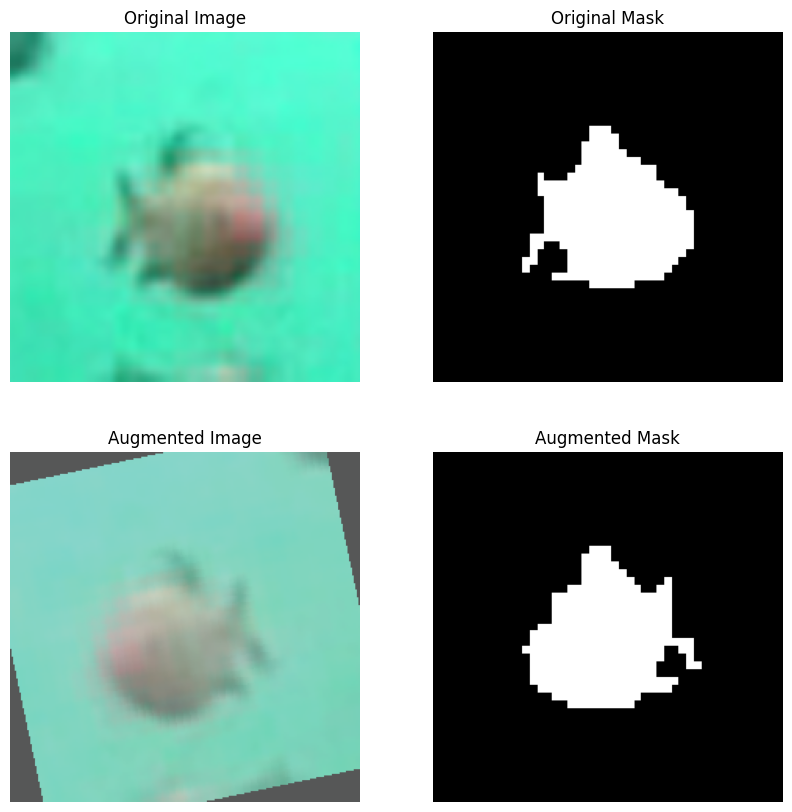

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define the normalization values used (update these if different)
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])  # ImageNet std

def denormalize(image):
    """Undo normalization: image = (image * std) + mean"""
    image = image * std + mean
    image = np.clip(image, 0, 1)  # Ensure values are in valid range
    return image

# Get a batch from DataLoader
images, masks = next(iter(train_loader))  # Unpack batch

# Ensure dataset has valid samples
total_samples = len(images)
assert total_samples >= 2, "Not enough images to visualize."

# Choose an even index to select the original image
idx = 14  # Pick any even index (0, 2, 4, etc.)
if idx % 2 != 0:
    idx -= 1  # Ensure it's even

aug_idx = idx + 1  # Augmented version is always at idx+1

# Extract images
original_image, original_mask = images[idx], masks[idx]
augmented_image, augmented_mask = images[aug_idx], masks[aug_idx]

# Convert tensors to NumPy
original_image = original_image.permute(1, 2, 0).numpy()
original_mask = original_mask.squeeze(0).numpy()

augmented_image = augmented_image.permute(1, 2, 0).numpy()
augmented_mask = augmented_mask.squeeze(0).numpy()

# **Undo Normalization**
original_image = denormalize(original_image)
augmented_image = denormalize(augmented_image)

# Plot images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(original_image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(original_mask, cmap="gray")
axes[0, 1].set_title("Original Mask")
axes[0, 1].axis("off")

axes[1, 0].imshow(augmented_image)
axes[1, 0].set_title("Augmented Image")
axes[1, 0].axis("off")

axes[1, 1].imshow(augmented_mask, cmap="gray")
axes[1, 1].set_title("Augmented Mask")
axes[1, 1].axis("off")

plt.show()


# TRAINING

In [4]:
# LOSS FUNCTIONS
LEARNING_RATE = 0.0001
EPOCHS = 20
torch.cuda.empty_cache()

focal_loss = smp.losses.FocalLoss(mode='binary', alpha=0.25, gamma=2)
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1e-6)
bce_loss = nn.BCELoss()

# with L2 regularization (Also add to docs)
l2_lambda = 1e-4
def combined_loss(outputs, labels):
    loss = dice_loss(outputs, labels) + bce_loss(outputs, labels)

    l2_reg = torch.tensor(0.0, device=outputs.device)
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)
    l2_reg = torch.clamp(l2_reg, max=1.0)


    return loss 

class UNetWithDropout(nn.Module):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", dropout_rate=0.5):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name=encoder_name,       
            encoder_weights=encoder_weights,    
            in_channels=3,                   
            classes=1,
            activation='sigmoid',
        )

        # Apply dropout to the decoder convolution layers
        self.dropout = nn.Dropout2d(p=dropout_rate)

    def forward(self, x):
        x = self.unet.encoder(x)  # Encoder
        x = self.unet.decoder(*x)  # Decoder
        x = self.dropout(x)  # Apply dropout
        x = self.unet.segmentation_head(x)  # Final segmentation head
        return x

# Instantiate model
model = UNetWithDropout(dropout_rate=0.5)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


augmented no scheduler 20 epoch result 2399 images

In [ ]:
# ADD TO DOCS THRESHOLD FOR IOU IS DURING EVAL 0.5 GO TO evaluate_model_unet() ask gpt  
history = train_model_unet(model.to(device), train_loader, val_loader, optimizer, combined_loss, epochs=EPOCHS, device=device)


Epoch 1/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [01:00<00:00,  1.98batch/s]


Epoch 1/20: Train Loss=1.2278, Train IoU=0.6362, Val Loss=1.0940, Val IoU=0.8593


Epoch 2/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 2/20: Train Loss=1.0302, Train IoU=0.8496, Val Loss=0.9711, Val IoU=0.8893


Epoch 3/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.07batch/s]


Epoch 3/20: Train Loss=0.9516, Train IoU=0.8851, Val Loss=0.9138, Val IoU=0.9009


Epoch 4/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.07batch/s]


Epoch 4/20: Train Loss=0.9112, Train IoU=0.8981, Val Loss=0.8692, Val IoU=0.9072


Epoch 5/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.07batch/s]


Epoch 5/20: Train Loss=0.8737, Train IoU=0.9015, Val Loss=0.8525, Val IoU=0.9083


Epoch 6/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 6/20: Train Loss=0.8534, Train IoU=0.9091, Val Loss=0.8390, Val IoU=0.9140


Epoch 7/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 7/20: Train Loss=0.8450, Train IoU=0.9129, Val Loss=0.8305, Val IoU=0.9155


Epoch 8/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.07batch/s]


Epoch 8/20: Train Loss=0.8310, Train IoU=0.9169, Val Loss=0.8233, Val IoU=0.9220


Epoch 9/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.05batch/s]


Epoch 9/20: Train Loss=0.8256, Train IoU=0.9188, Val Loss=0.8220, Val IoU=0.9197


Epoch 10/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.03batch/s]


Epoch 10/20: Train Loss=0.8179, Train IoU=0.9216, Val Loss=0.8168, Val IoU=0.9243


Epoch 11/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:56<00:00,  2.12batch/s]


Epoch 11/20: Train Loss=0.8130, Train IoU=0.9227, Val Loss=0.8145, Val IoU=0.9241


Epoch 12/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:56<00:00,  2.12batch/s]


Epoch 12/20: Train Loss=0.8061, Train IoU=0.9269, Val Loss=0.8151, Val IoU=0.9217


Epoch 13/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 13/20: Train Loss=0.8052, Train IoU=0.9248, Val Loss=0.8162, Val IoU=0.9213


Epoch 14/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.09batch/s]


Epoch 14/20: Train Loss=0.7991, Train IoU=0.9267, Val Loss=0.8148, Val IoU=0.9209


Epoch 15/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 15/20: Train Loss=0.7953, Train IoU=0.9298, Val Loss=0.8121, Val IoU=0.9233


Epoch 16/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 16/20: Train Loss=0.7955, Train IoU=0.9291, Val Loss=0.8128, Val IoU=0.9228


Epoch 17/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.10batch/s]


Epoch 17/20: Train Loss=0.7904, Train IoU=0.9326, Val Loss=0.8151, Val IoU=0.9196


Epoch 18/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 18/20: Train Loss=0.7884, Train IoU=0.9374, Val Loss=0.8104, Val IoU=0.9264


Epoch 19/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 19/20: Train Loss=0.7876, Train IoU=0.9316, Val Loss=0.8123, Val IoU=0.9244


Epoch 20/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]


Epoch 20/20: Train Loss=0.7878, Train IoU=0.9353, Val Loss=0.8113, Val IoU=0.9264


In [ ]:

#not augmented no scheduler 20 epoch result 2399 images
Epoch 1/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 1/20: Train Loss=1.1401, Train IoU=0.6851, Val Loss=0.9383, Val IoU=0.8647
Epoch 2/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 2/20: Train Loss=0.9328, Train IoU=0.8648, Val Loss=0.8766, Val IoU=0.8942
Epoch 3/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 3/20: Train Loss=0.8935, Train IoU=0.8966, Val Loss=0.8540, Val IoU=0.9049
Epoch 4/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.05batch/s]
Epoch 4/20: Train Loss=0.8697, Train IoU=0.9094, Val Loss=0.8402, Val IoU=0.9133
Epoch 5/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 5/20: Train Loss=0.8550, Train IoU=0.9151, Val Loss=0.8291, Val IoU=0.9181
Epoch 6/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.05batch/s]
Epoch 6/20: Train Loss=0.8393, Train IoU=0.9210, Val Loss=0.8215, Val IoU=0.9244
Epoch 7/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [01:01<00:00,  1.96batch/s]
Epoch 7/20: Train Loss=0.8285, Train IoU=0.9282, Val Loss=0.8195, Val IoU=0.9241
Epoch 8/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]
Epoch 8/20: Train Loss=0.8256, Train IoU=0.9258, Val Loss=0.8171, Val IoU=0.9259
Epoch 9/20 lr = 0.0001: 100%|██████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 9/20: Train Loss=0.8192, Train IoU=0.9306, Val Loss=0.8163, Val IoU=0.9229
Epoch 10/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]
Epoch 10/20: Train Loss=0.8131, Train IoU=0.9320, Val Loss=0.8151, Val IoU=0.9232
Epoch 11/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.07batch/s]
Epoch 11/20: Train Loss=0.8090, Train IoU=0.9344, Val Loss=0.8129, Val IoU=0.9240
Epoch 12/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.04batch/s]
Epoch 12/20: Train Loss=0.8035, Train IoU=0.9362, Val Loss=0.8112, Val IoU=0.9263
Epoch 13/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 13/20: Train Loss=0.7997, Train IoU=0.9377, Val Loss=0.8138, Val IoU=0.9234
Epoch 14/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 14/20: Train Loss=0.7978, Train IoU=0.9376, Val Loss=0.8132, Val IoU=0.9246
Epoch 15/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:59<00:00,  2.03batch/s]
Epoch 15/20: Train Loss=0.7925, Train IoU=0.9412, Val Loss=0.8128, Val IoU=0.9242
Epoch 16/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 16/20: Train Loss=0.7886, Train IoU=0.9402, Val Loss=0.8104, Val IoU=0.9275
Epoch 17/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.08batch/s]
Epoch 17/20: Train Loss=0.7868, Train IoU=0.9419, Val Loss=0.8121, Val IoU=0.9248
Epoch 18/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.07batch/s]
Epoch 18/20: Train Loss=0.7855, Train IoU=0.9429, Val Loss=0.8097, Val IoU=0.9290
Epoch 19/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:58<00:00,  2.06batch/s]
Epoch 19/20: Train Loss=0.7817, Train IoU=0.9470, Val Loss=0.8123, Val IoU=0.9275
Epoch 20/20 lr = 0.0001: 100%|█████████████████████████████████| 120/120 [00:57<00:00,  2.07batch/s]
Epoch 20/20: Train Loss=0.7804, Train IoU=0.9465, Val Loss=0.8127, Val IoU=0.9270

# VISUALIZATION

**COMPARE ORIGINAL VS GROUND TRUTH MASK**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].


Image shape: (224, 224, 3)
Mask shape: (224, 224)


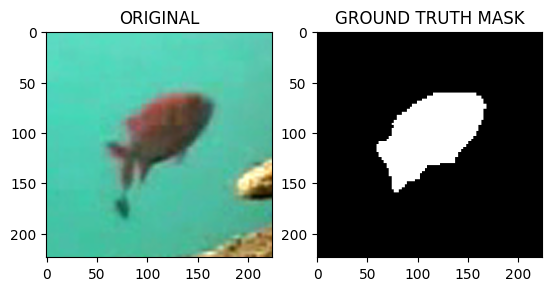

In [7]:
def show_sample(loader):
    # Get a batch of images and masks
    batch = next(iter(loader))
    
    # Access the image and mask tensors from the batch
    images, masks = batch  # Unpack the tuple
    
    # Get the first image and mask from the batch
    image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC
    mask = masks[0].squeeze().numpy()  # Remove the single channel and convert to numpy

    # Reverse normalization to bring image back to [0, 1] range for display
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Reverse normalization

    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    
    # Plot image and mask
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("ORIGINAL")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Mask is a single channel image, so use gray colormap
    plt.title("GROUND TRUTH MASK")
    
    plt.show()

# Display sample from training, validation, and test sets
show_sample(train_loader)


**TRAINING GRAPH**

AUGMENTED

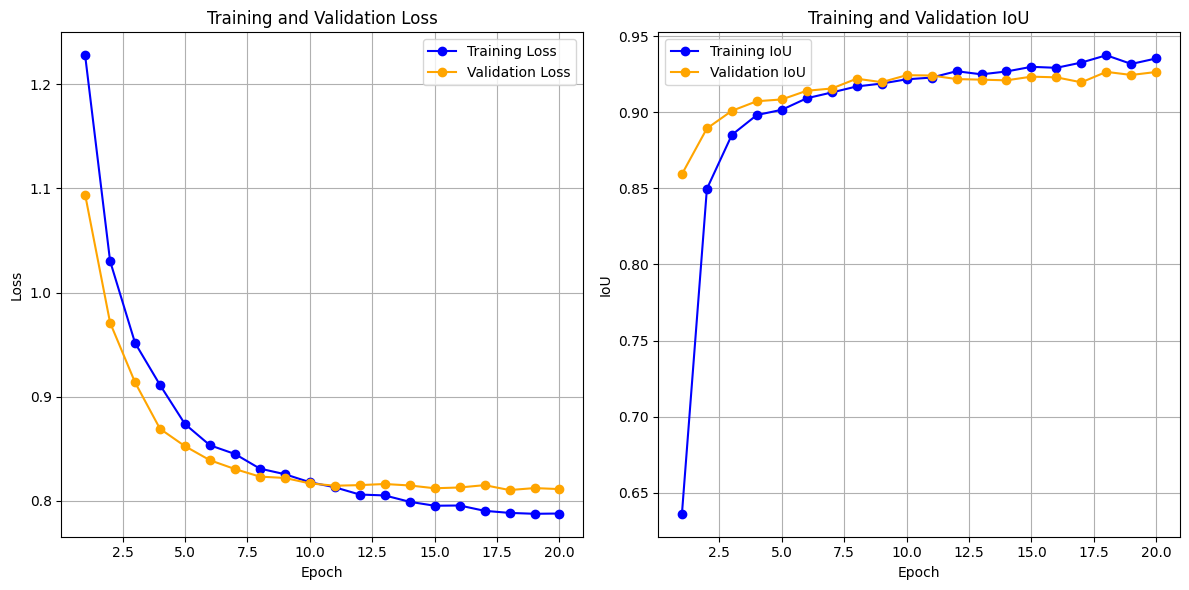

In [ ]:
# loaded_history = load_history_from_csv('./saved_models/history/unet_history224-ESRGAN.csv')
plot_history_unet(history, max_epochs=20) 

NOT AUGMENTED

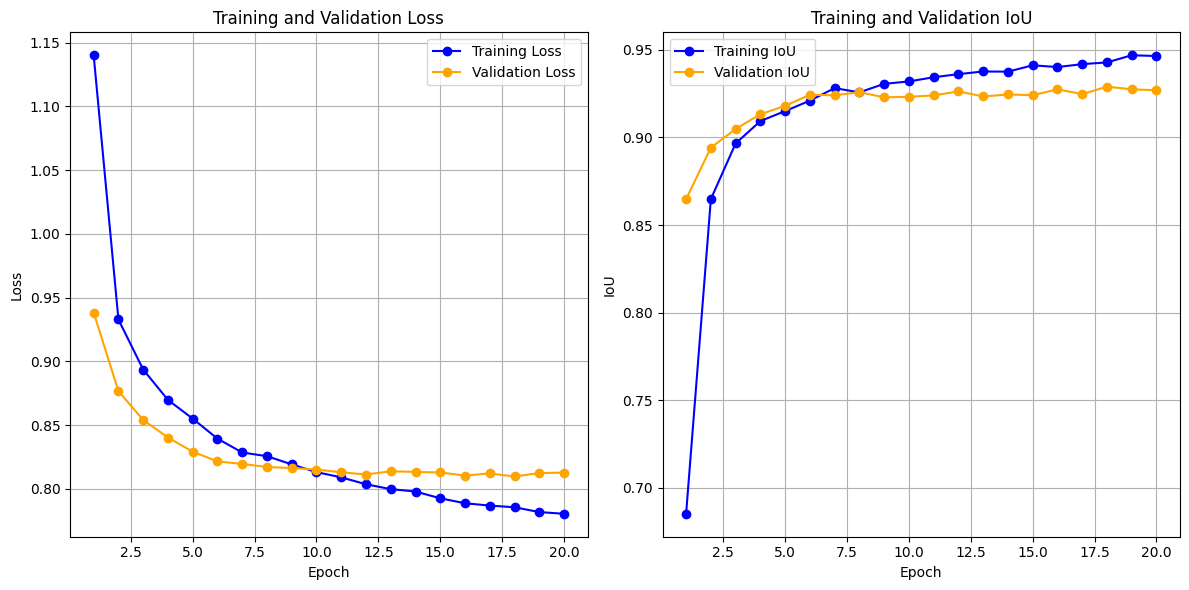

In [ ]:
plot_history_unet(history, max_epochs=20) 

**FEATURE EXTRACTION**

In [240]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2

# Load an image (example image)
img_path = "./TESTS/images/LR/Acanthurus Nigrofuscus.png"  # Change this to your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_resized = cv2.resize(img, (256, 256))  # Resize to match input size

# Convert image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize like ImageNet
])

input_tensor = transform(img_resized).unsqueeze(0)  # Add batch dimension

# Move the input tensor to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

# Get feature maps from the encoder
encoder_layers = model.unet.encoder  
decoder_layers = model.unet.decoder

model.to(device)  # Ensure the model is on the same device

with torch.no_grad():
    x = input_tensor
    feature_maps = []
    for layer in encoder_layers.children():
        x = layer(x)  # Forward pass
        feature_maps.append(x)  # Store feature maps
    decoder_feature_maps = []
    for layer in decoder_layers.children():
        try:
            x = layer(x)  # Some layers may require skip connections
        except:
            pass  # Skip layers that require additional inputs (e.g., concatenation layers)
        
        decoder_feature_maps.append(x)  # Store feature maps

# Print number of extracted feature maps
for i, fmap in enumerate(feature_maps):
    print(f"Layer {i+1}: {fmap.shape}")  # Shape: (batch_size, channels, height, width)

for i, fmap in enumerate(decoder_feature_maps):
    print(f"Decoder Layer {i+1}: {fmap.shape}")  # Shape: (batch_size, channels, height, width)


Layer 1: torch.Size([1, 64, 128, 128])
Layer 2: torch.Size([1, 64, 128, 128])
Layer 3: torch.Size([1, 64, 128, 128])
Layer 4: torch.Size([1, 64, 64, 64])
Layer 5: torch.Size([1, 64, 64, 64])
Layer 6: torch.Size([1, 128, 32, 32])
Layer 7: torch.Size([1, 256, 16, 16])
Layer 8: torch.Size([1, 512, 8, 8])
Decoder Layer 1: torch.Size([1, 512, 8, 8])
Decoder Layer 2: torch.Size([1, 512, 8, 8])


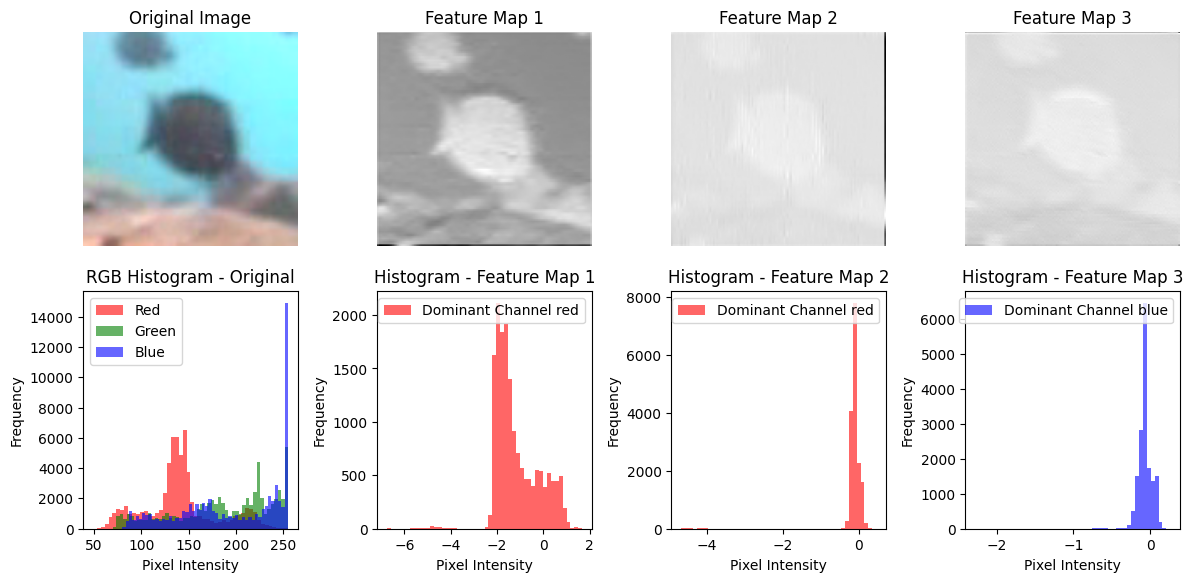

In [239]:
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "./TESTS/images/LR/Acanthurus Nigrofuscus.png"  
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
img_resized = cv2.resize(img, (256, 256))  

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize like ImageNet
])

input_tensor = transform(img_resized).unsqueeze(0) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

model.to(device)
model.eval()

# Get the first layer's feature maps from the encoder
first_layer = list(model.unet.encoder.children())[0]  # Get the first layer
with torch.no_grad():
    feature_maps = first_layer(input_tensor)  # Get feature maps from the first layer

# Get the number of feature maps (channels)
num_feature_maps = feature_maps.shape[1]
num_display = min(3, num_feature_maps)  # Display only the first 3 feature maps

# Create figure with multiple columns (Original + Feature Maps)
fig, axes = plt.subplots(2, num_display + 1, figsize=(12, 6))  # Original Image + Feature Maps

# Function to normalize feature map for visualization
def normalize_feature_map(fmap):
    fmap = fmap.cpu().numpy()  # Convert to NumPy (C, H, W)
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())  # Normalize to [0, 1]
    return fmap

# Function to compute histogram for a feature map (1 dominant channel)
def compute_channel_histogram(fmap):
    fmap = fmap.squeeze(0).cpu().numpy()  # Convert to NumPy (C, H, W)
    return fmap.flatten()

# Function to find the dominant color of the feature map
def get_dominant_color(feature_map, original_img):
    # Resize feature map to match original image size
    feature_map_resized = cv2.resize(feature_map.squeeze(0).cpu().numpy(), (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_LINEAR)
    
    # Flatten the feature map and original image channels
    fmap_values = feature_map_resized.flatten()
    r_values = original_img[:, :, 0].flatten()
    g_values = original_img[:, :, 1].flatten()
    b_values = original_img[:, :, 2].flatten()
    
    # Ensure all arrays are of the same size
    assert len(fmap_values) == len(r_values) == len(g_values) == len(b_values), "Arrays must be of the same length"

    # Compute correlation between feature map and each color channel
    r_corr = np.corrcoef(fmap_values, r_values)[0, 1]
    g_corr = np.corrcoef(fmap_values, g_values)[0, 1]
    b_corr = np.corrcoef(fmap_values, b_values)[0, 1]
    
    # Determine which channel has the highest correlation
    if r_corr >= g_corr and r_corr >= b_corr:
        return 'red', r_corr
    elif g_corr >= r_corr and g_corr >= b_corr:
        return 'green', g_corr
    else:
        return 'blue', b_corr

# Plot original image
axes[0, 0].imshow(img_resized)  # Show RGB image
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

# Compute RGB histogram for original image
r_hist, g_hist, b_hist = img_resized[:, :, 0].flatten(), img_resized[:, :, 1].flatten(), img_resized[:, :, 2].flatten()

# Plot RGB histograms for original image
axes[1, 0].hist(r_hist, bins=50, color='red', alpha=0.6, label='Red')
axes[1, 0].hist(g_hist, bins=50, color='green', alpha=0.6, label='Green')
axes[1, 0].hist(b_hist, bins=50, color='blue', alpha=0.6, label='Blue')
axes[1, 0].set_title("RGB Histogram - Original")
axes[1, 0].set_xlabel("Pixel Intensity")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].legend()

# Plot first 3 feature maps and their histograms
for i in range(num_display):
    fmap = feature_maps[0, i]  # Extract i-th feature map (still a tensor)

    # Plot feature map
    axes[0, i + 1].imshow(fmap.cpu().numpy(), cmap="gray")
    axes[0, i + 1].set_title(f"Feature Map {i+1}")
    axes[0, i + 1].axis("off")

    # Compute and plot histogram for the feature map channel
    channel_values = compute_channel_histogram(fmap)
    
    # Get dominant color for this feature map's channel
    color, _ = get_dominant_color(fmap, img_resized)
    
    # Plot the histogram with the dominant color
    axes[1, i + 1].hist(channel_values, bins=50, color=color, alpha=0.6, label=f'Dominant Channel {color}')
    axes[1, i + 1].set_title(f"Histogram - Feature Map {i+1}")
    axes[1, i + 1].set_xlabel("Pixel Intensity")
    axes[1, i + 1].set_ylabel("Frequency")
    axes[1, i + 1].legend()

plt.tight_layout()
plt.show()


img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)
img shape: (128, 128)


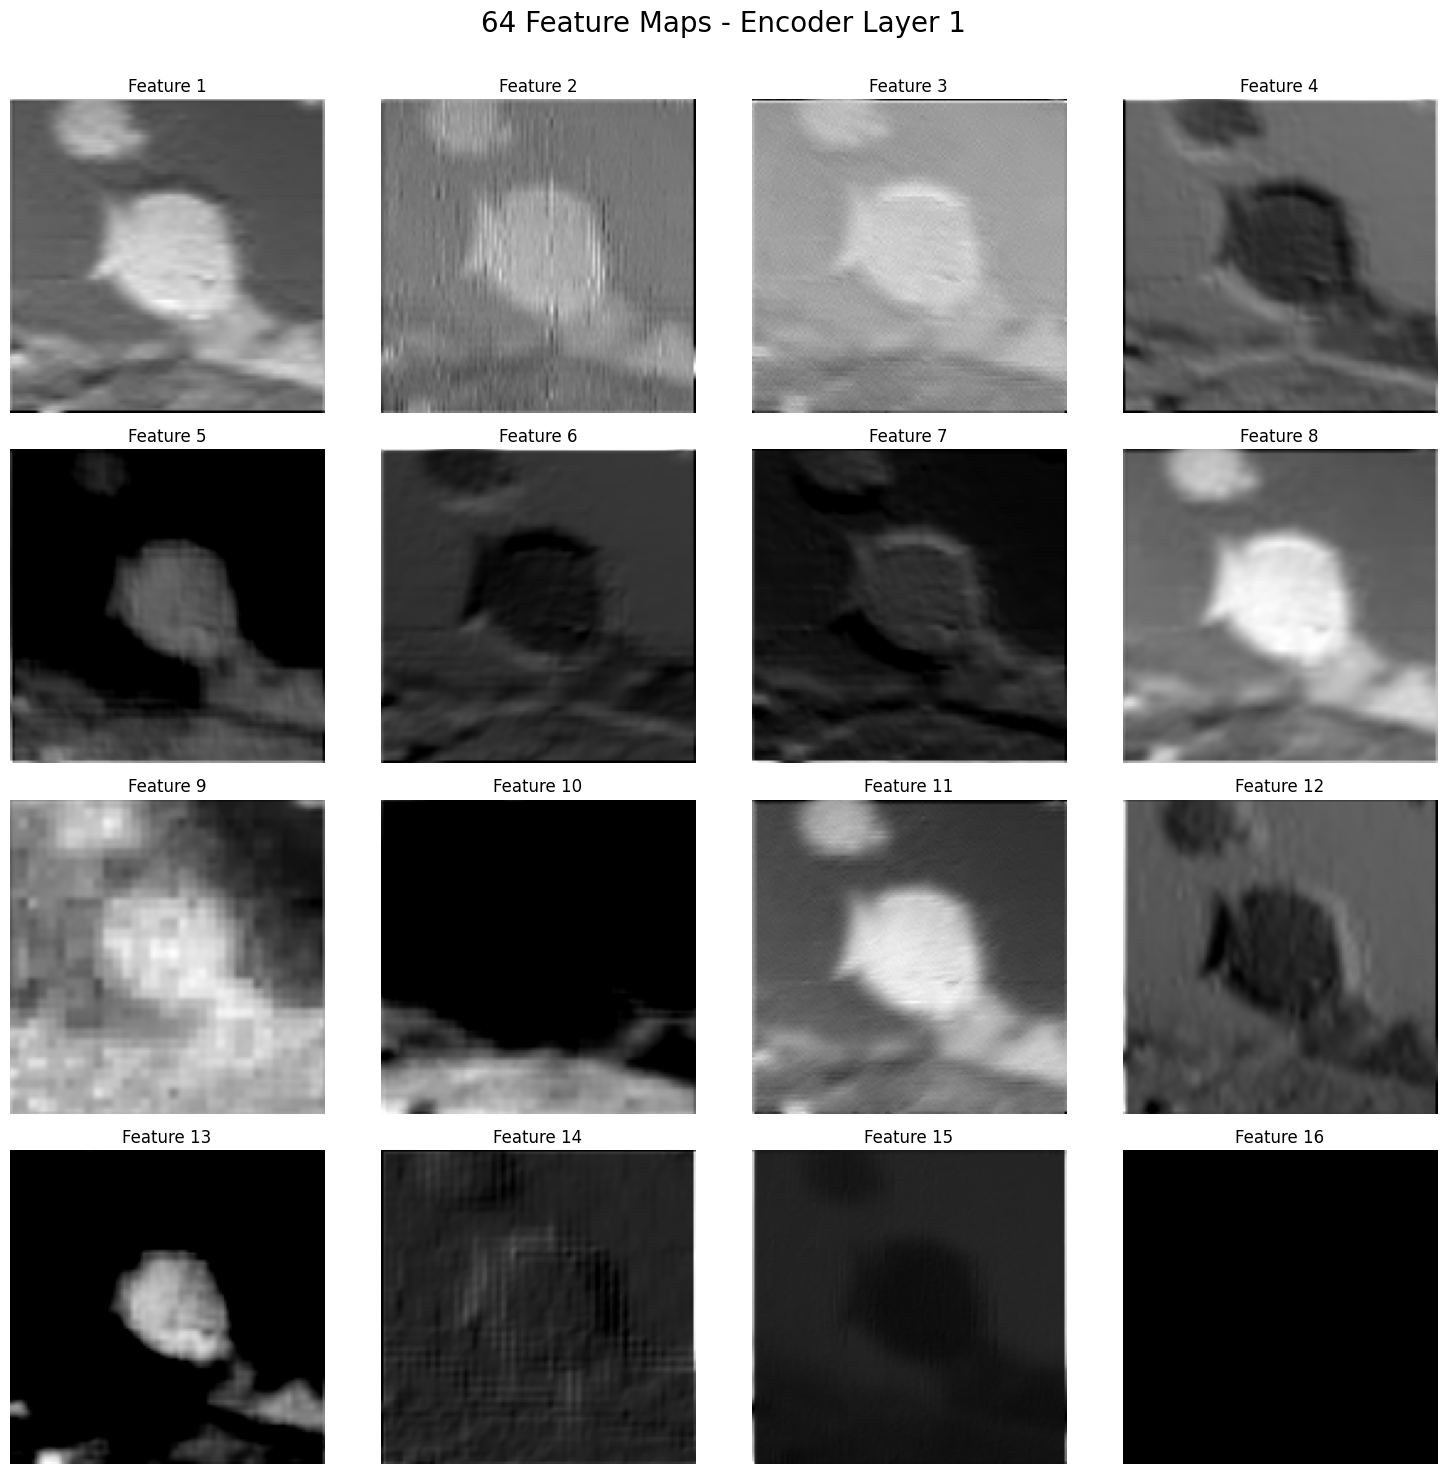

In [242]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_all_feature_maps(feature_maps, layer_idx, grid_size=(8, 8), title="Feature Maps"):
    fmap = feature_maps[layer_idx].cpu().numpy()  # Convert to NumPy

    if len(fmap.shape) == 4:  # Remove batch dimension
        fmap = fmap[0]  # Shape: (64, 128, 128)

    num_channels, height, width = fmap.shape  # (64, 128, 128)
    
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    fig.suptitle(title, fontsize=20)

    for i, ax in enumerate(axes.flat):
        if i >= num_channels:
            ax.axis("off")
            continue
        # Normalize each feature map for better visualization
        img = fmap[i]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # Normalize 0-1
        print('img shape:', img.shape) 
        
        ax.imshow(img, cmap="gray")  # Grayscale
        ax.axis("off")
        ax.set_title(f"Feature {i+1}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust title spacing
    plt.show()

# Call function to plot all 64 feature maps
visualize_all_feature_maps(feature_maps, layer_idx=1, grid_size=(4, 4), title="64 Feature Maps - Encoder Layer 1")


**TEST SET EVALUATION OF IOU**

TEST SET ( AUGMENTED )

In [25]:
l2_lambda = 1e-4
def combined_loss(outputs, labels):
    loss = dice_loss(outputs, labels) + bce_loss(outputs, labels)

    l2_reg = torch.tensor(0.0, device=outputs.device)
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)
    l2_reg = torch.clamp(l2_reg, max=1.0)


    return loss 

val_loss, val_iou = evaluate_model_unet(model, test_loader, combined_loss, device)

print(f"TEST SET Loss: {val_loss:.4f}")
print(f"TESET SET IoU: {val_iou:.4f}")

TEST SET Loss: 0.8091
TESET SET IoU: 0.9308


TEST SET ( NOT AUGMENTED )

In [27]:
l2_lambda = 1e-4
def combined_loss(outputs, labels):
    loss = dice_loss(outputs, labels) + bce_loss(outputs, labels)

    l2_reg = torch.tensor(0.0, device=outputs.device)
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)
    l2_reg = torch.clamp(l2_reg, max=1.0)


    return loss 

val_loss, val_iou = evaluate_model_unet(model, test_loader, combined_loss, device)

print(f"TEST SET Loss: {val_loss:.4f}")
print(f"TESET SET IoU: {val_iou:.4f}")

TEST SET Loss: 0.8119
TESET SET IoU: 0.9244


**COMPARE ALL IMAGES VS GROUND TRUTH VS PREDICTED VS MASK**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


Class SPECIE: Abudefduf Vaigiensis


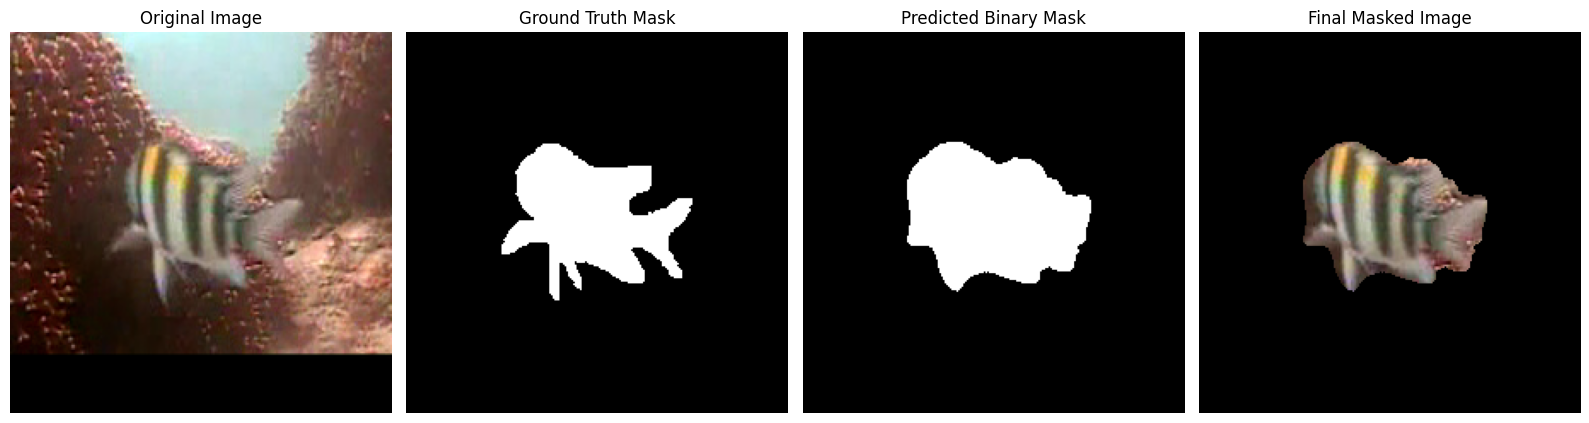

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9803921356201173].



Average IoU: 0.9225
Class SPECIE: Acanthurus Nigrofuscus


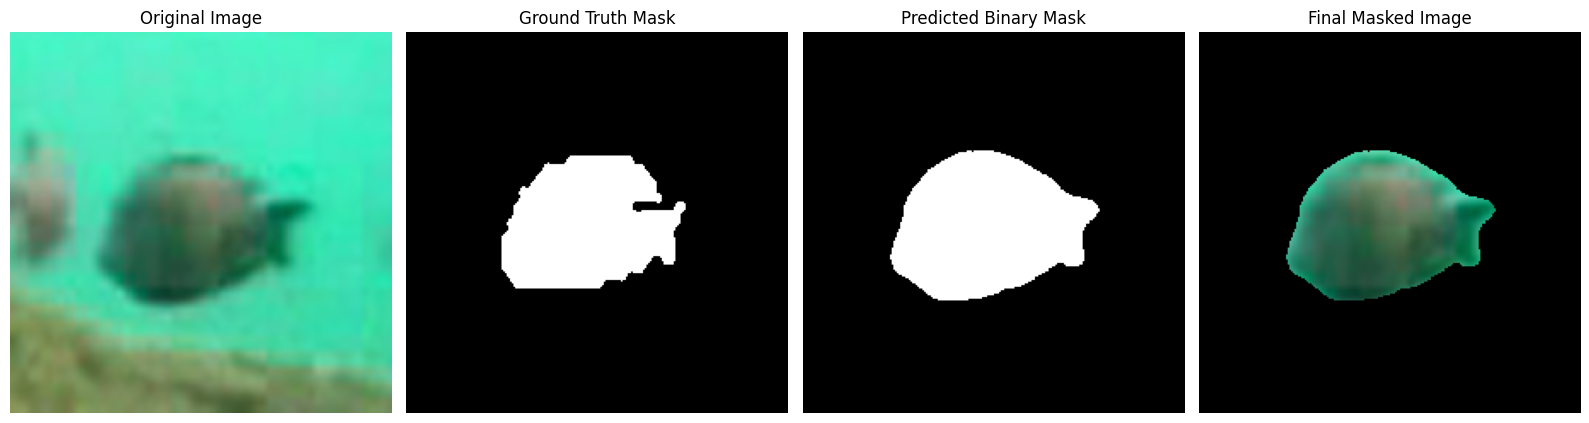

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05490195131301884..1.0000000236034394].



Average IoU: 0.9467
Class SPECIE: Balistapus Undulatus


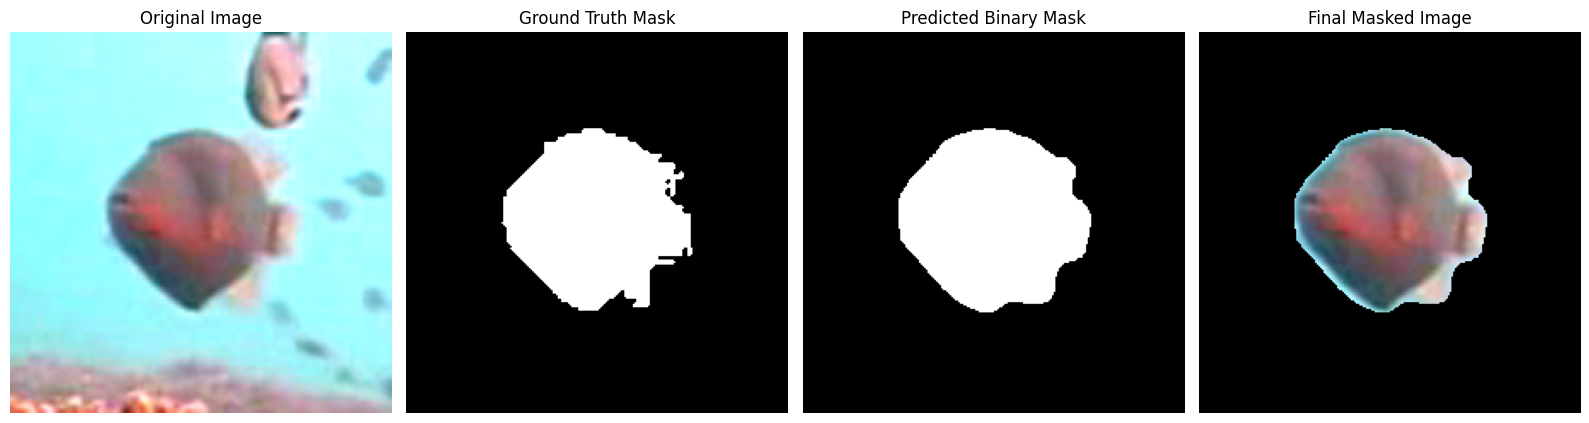

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9610
Class SPECIE: Canthigaster Valentini


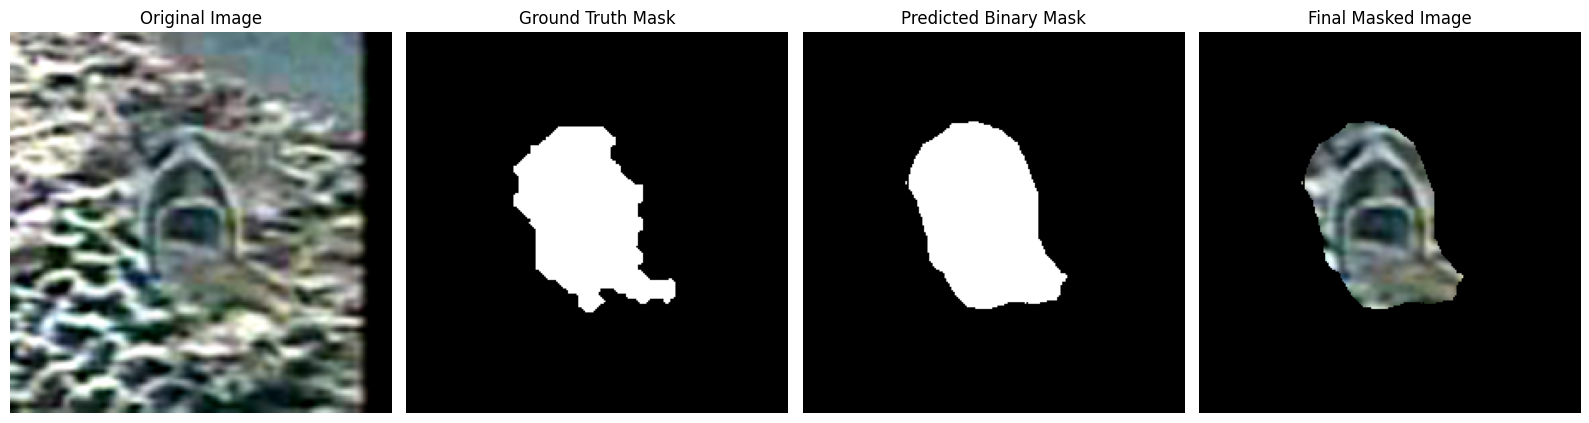

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].



Average IoU: 0.9236
Class SPECIE: Chaetodon Trifascialis


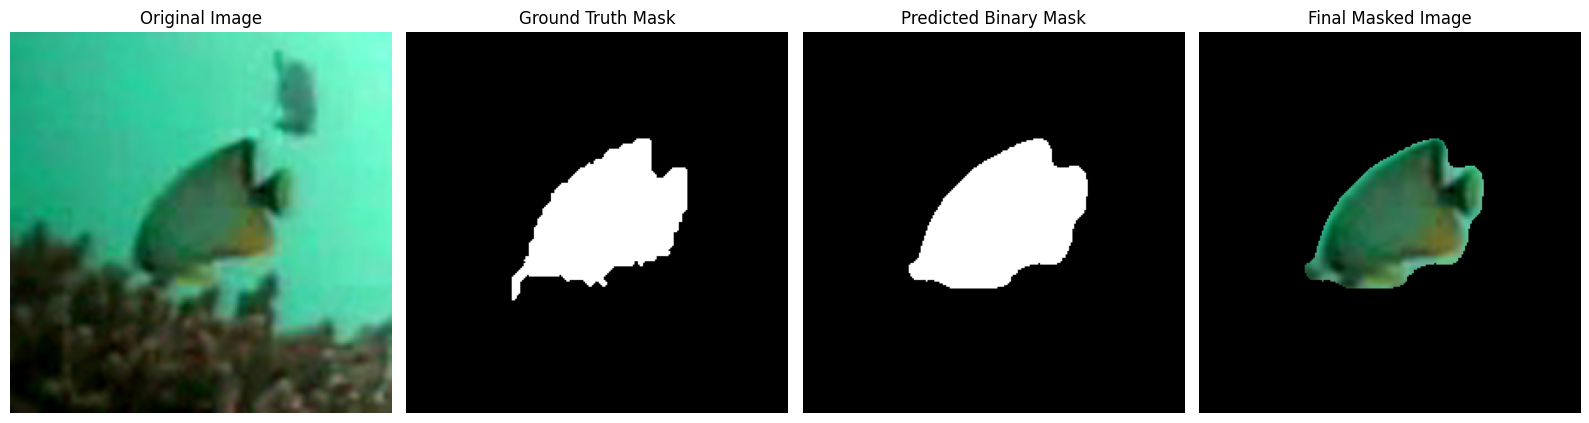

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9215686264038085].



Average IoU: 0.9363
Class SPECIE: Hemigymnus Fasciatus


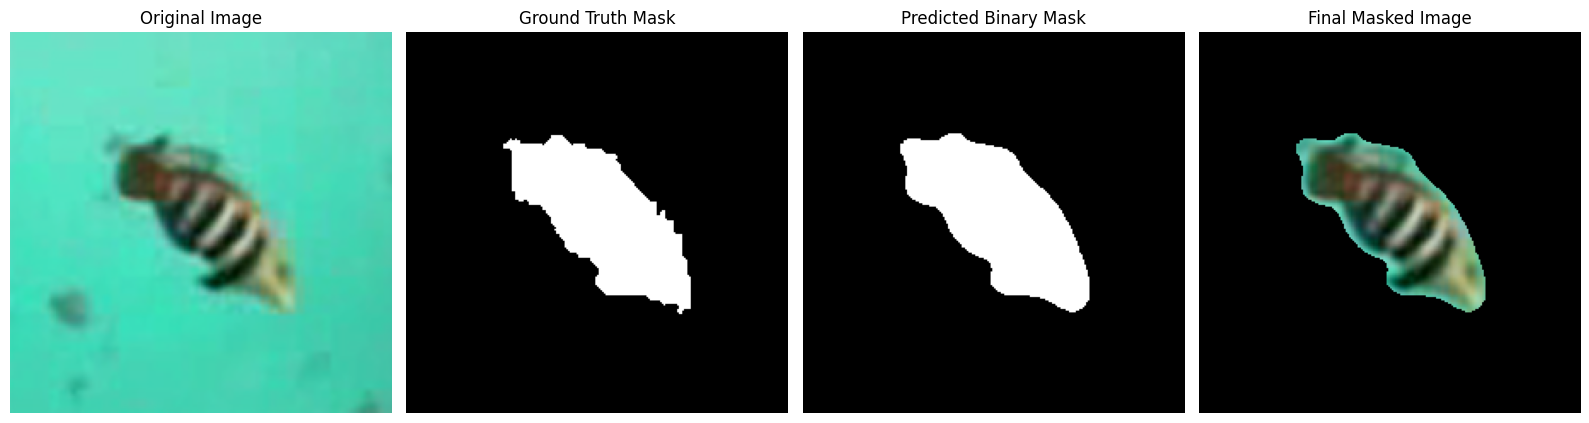

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14117645311355587..1.0000000236034394].



Average IoU: 0.9488
Class SPECIE: Hemigymnus Melapterus


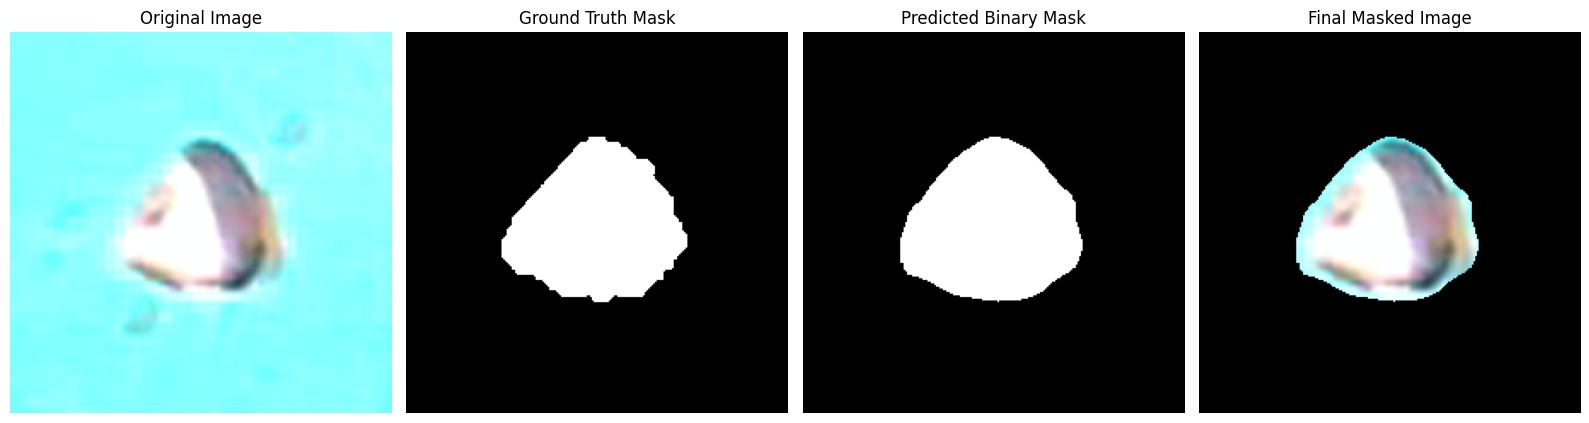

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9320
Class SPECIE: Lutjanus fulvus


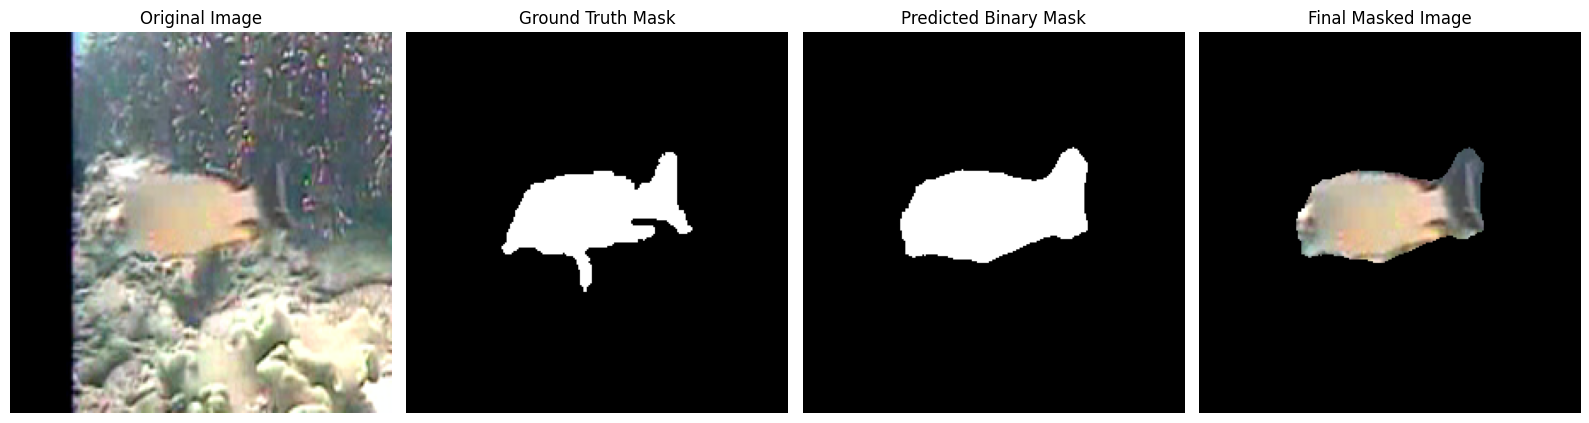

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16470586264133452..1.0000000076293944].



Average IoU: 0.9187
Class SPECIE: Myripristis Kuntee


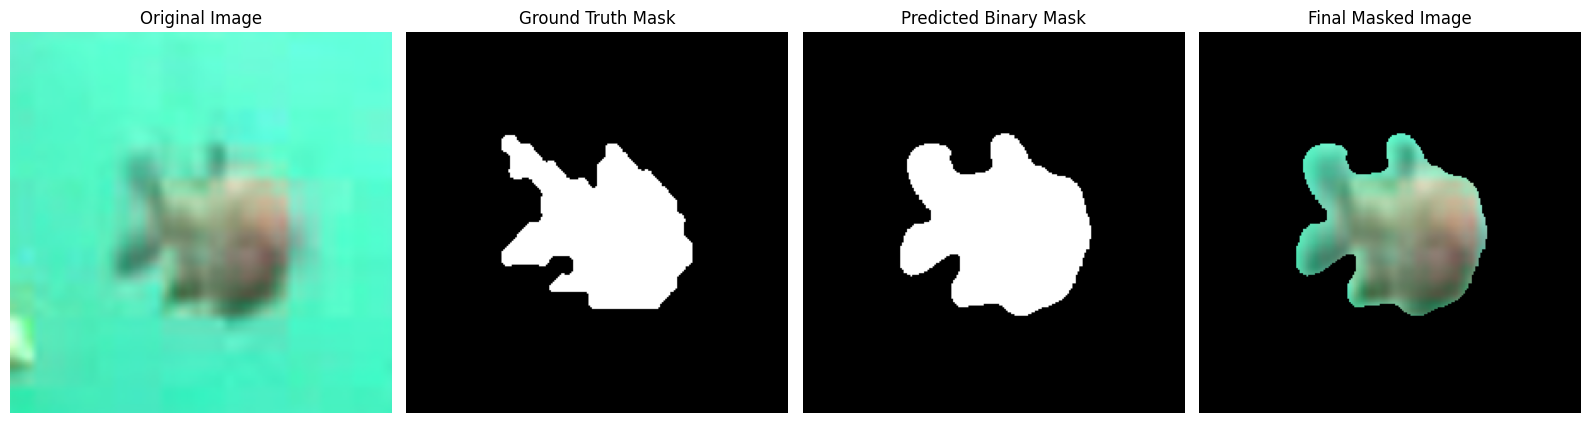

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9222
Class SPECIE: Neoglyphidodon Nigroris


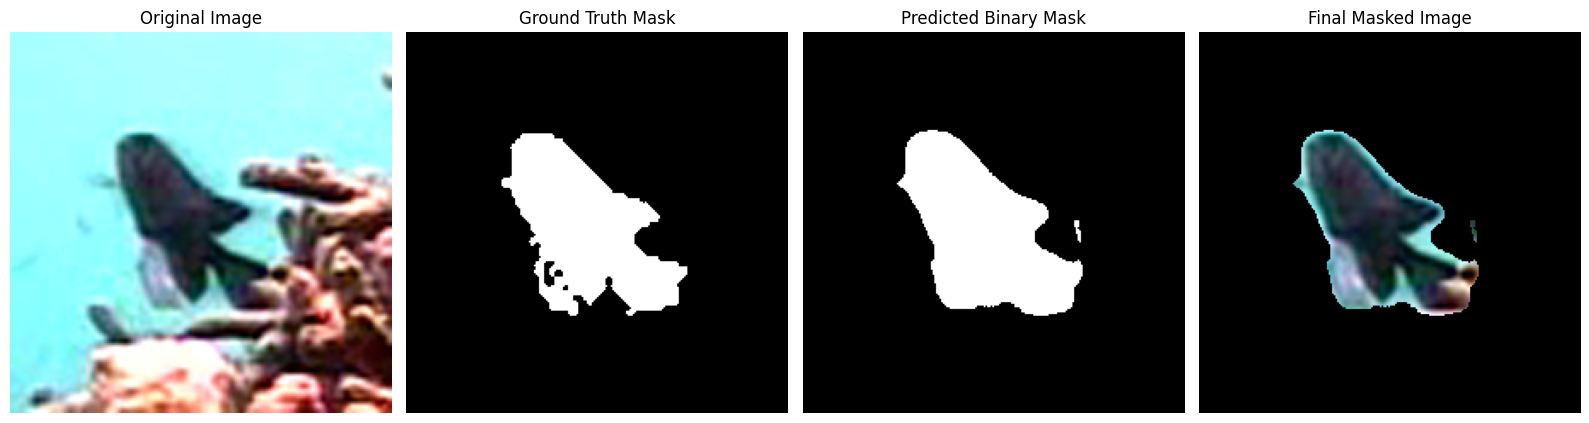

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9520
Class SPECIE: Neoniphon Sammara


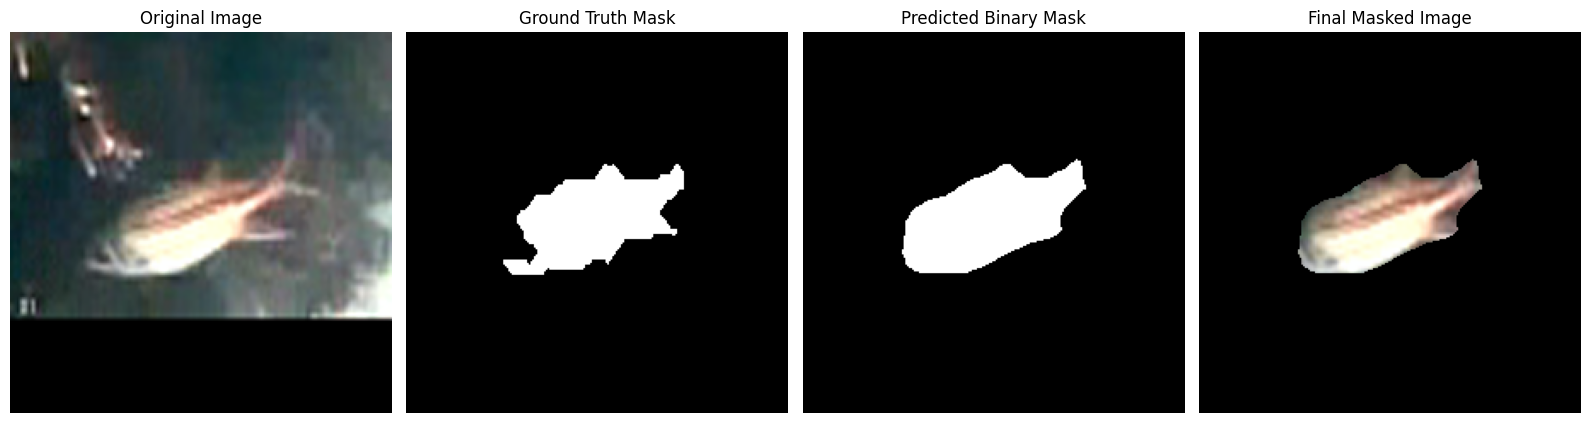

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9103
Class SPECIE: Pempheris Vanicolensis


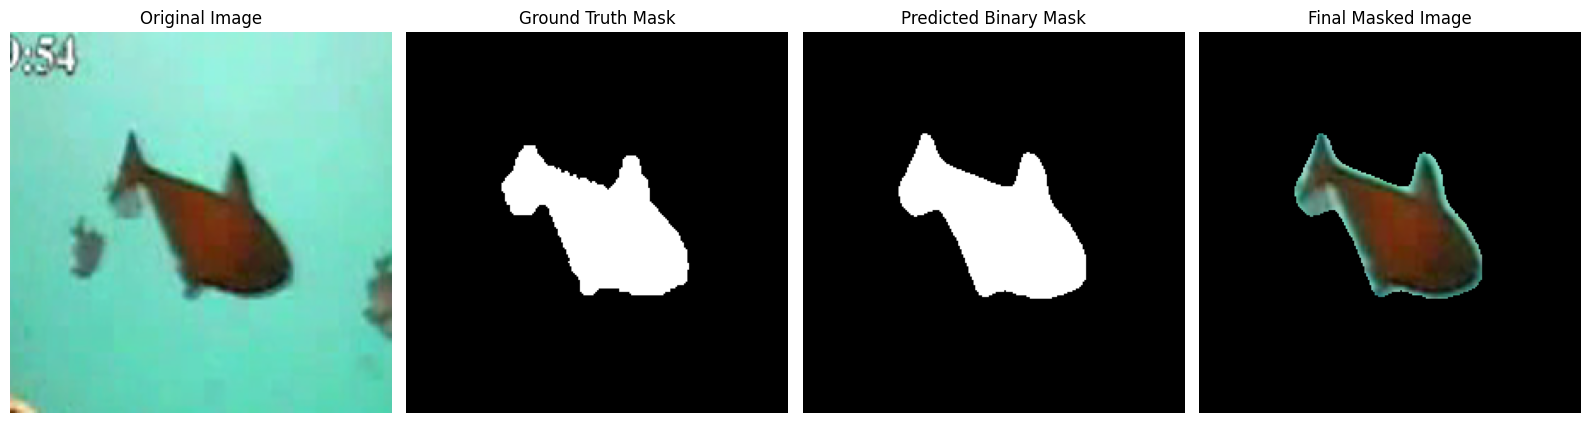

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9588
Class SPECIE: Pomacentrus Moluccensis


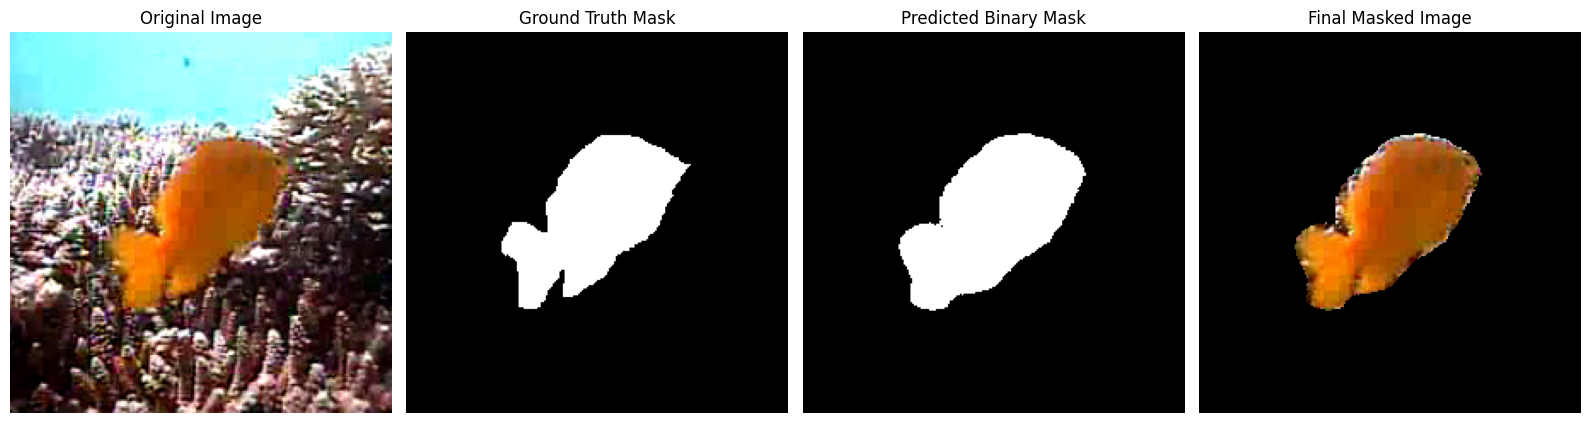

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8352941284179688].



Average IoU: 0.9316
Class SPECIE: Scaridae


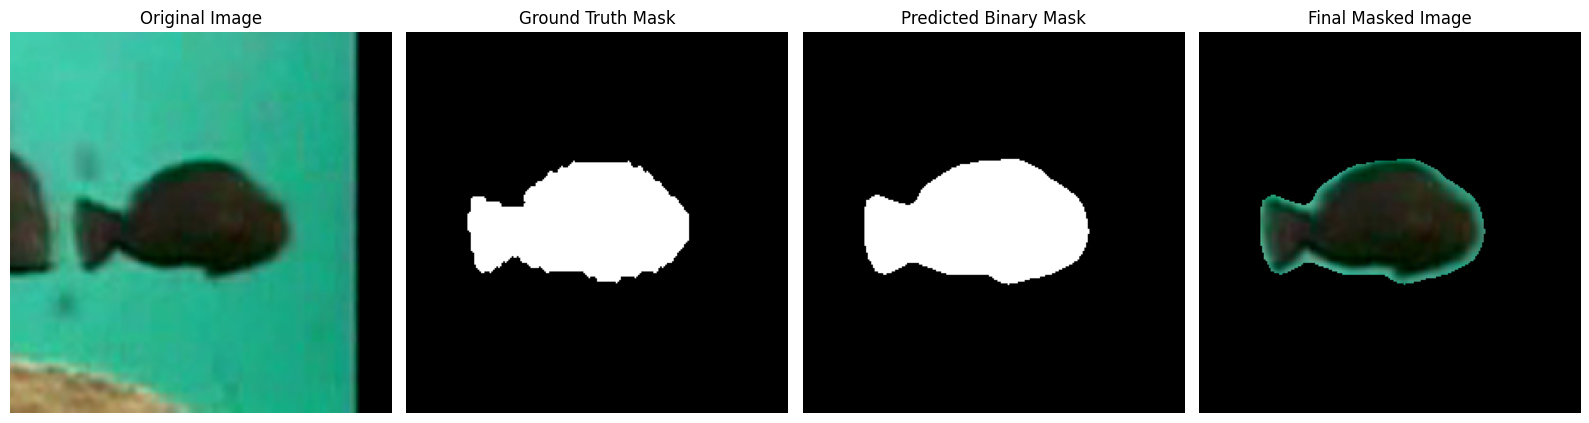

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9596
Class SPECIE: Scolopsis Bilineata


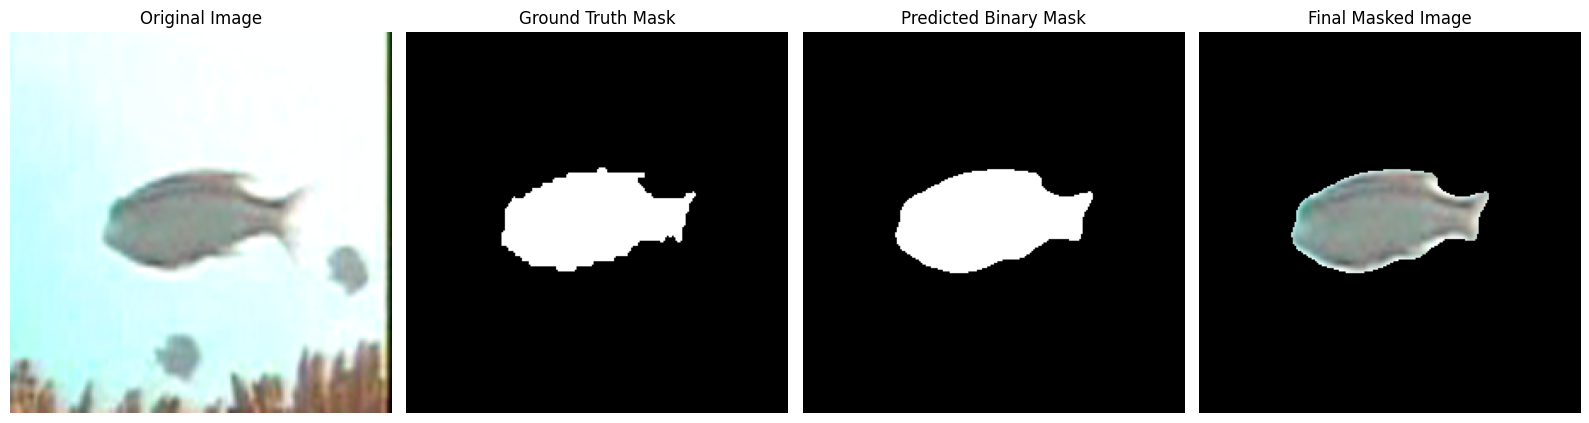

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9355
Class SPECIE: Siganus Fuscescens


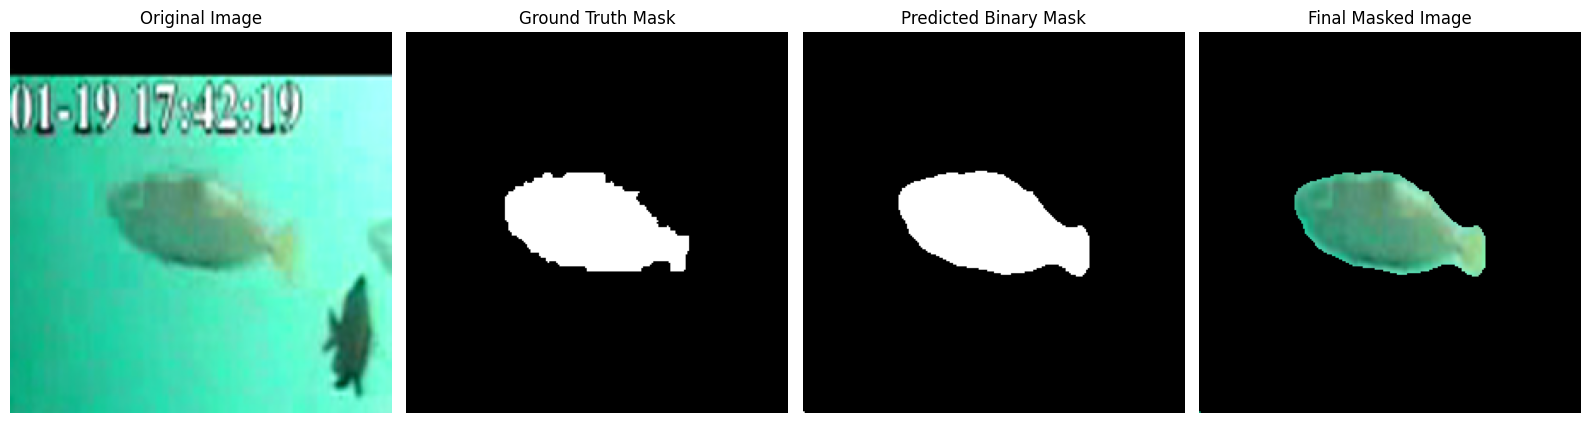

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].



Average IoU: 0.9436
Class SPECIE: Zanclus Cornutus


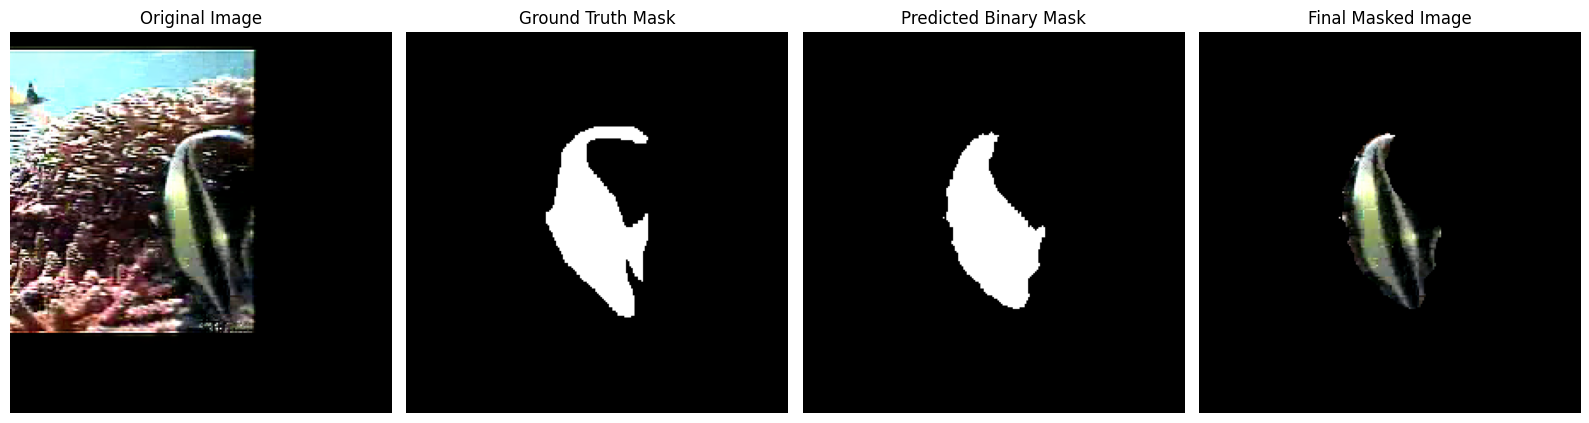

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].



Average IoU: 0.9001
Class SPECIE: Zebrasoma Scopas


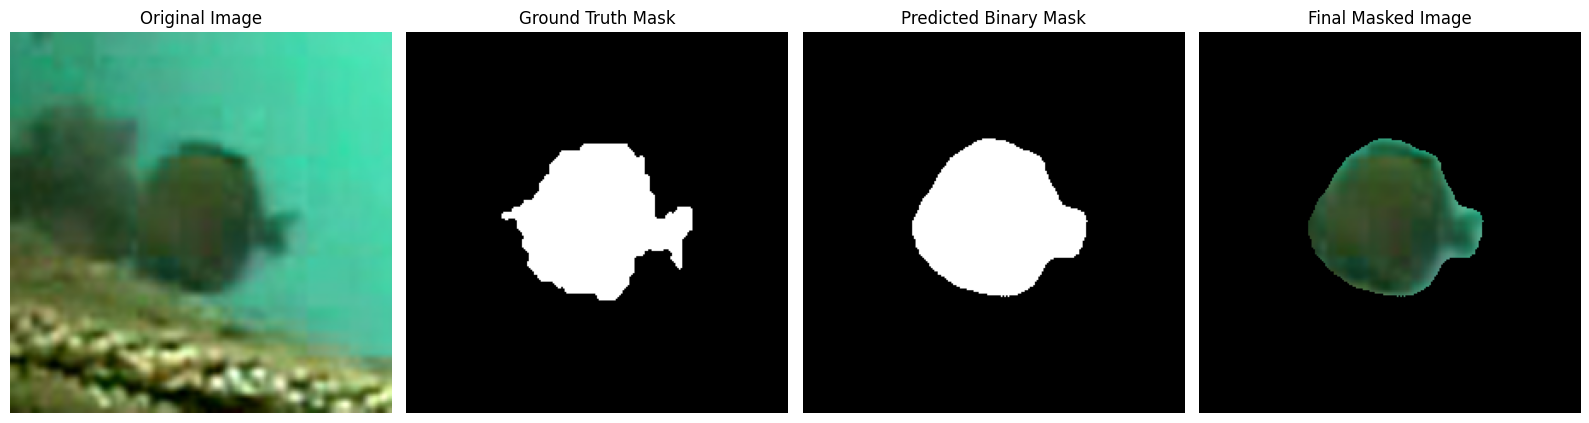


Average IoU: 0.9590

TOTAL Average IoU for all Specie: 0.9318


In [ ]:

SIZE_X, SIZE_Y = 224, 224

# Define paths for input and output directories
input_dirs = {"test": "./DATASET/TEST_ESRGAN2 - ESRGAN"}
output_dirs = {"test": "./DATASET/TEST_ESRGAN2_UNET"}
mask_dir = './DATASET/TRAIN_UNET/mask'

# Parameters
threshold = 0.3

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]
    mask_filename = f"mask_{fishnumber}.png"
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")
        return None


def preprocess_image(image_path):
    # Read the image
    img = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    
    img = transform(img)
    return img
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def compute_iou(preds, labels, threshold=0.5, num_classes=2):
    """Computes IoU for binary segmentation masks"""
    preds = (preds > threshold).astype(int)  # Binary thresholding
    
    ious = []
    for i in range(num_classes):  # For each class (0 and 1 for binary segmentation)
        intersection = np.sum((preds == i) & (labels == i))
        union = np.sum((preds == i) | (labels == i))
        iou = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou)

    return np.mean(ious)

def process_all(model, device):
    """Processes all images, applies model prediction, computes IoU, and visualizes results"""
    total_iou = 0.0
    total_images = 0

    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)

            specie_images = 0
            specie_iou = 0
            display_count = 0

            for img_name in os.listdir(species_dir):
                img_path = os.path.join(species_dir, img_name)

                # Load & preprocess image
                image = preprocess_image(img_path).unsqueeze(0).to(device)  # Add batch dimension

                # Load ground truth mask
                ground_truth_path = get_corresponding_mask(img_name)
                ground_truth_mask = cv2.imread(ground_truth_path, 0)
                ground_truth_mask = cv2.resize(ground_truth_mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_CUBIC)

                with torch.no_grad(): 
                    model.eval()  
                    predicted_mask = model(image)  # Model already applies sigmoid

                predicted_mask = predicted_mask.squeeze().cpu().numpy()

                # Apply thresholding for binary mask
                binary_mask = (predicted_mask > 0.3).astype(np.uint8)

                # Ensure ground truth mask is binary (convert from grayscale 0-255 to 0-1)
                if ground_truth_mask.max() > 1:
                    ground_truth_mask = (ground_truth_mask > 127).astype(np.uint8)

                # Compute IoU
                ious = []
                for i in range(2):  # Binary segmentation (0 and 1)
                    intersection = np.logical_and(binary_mask == i, ground_truth_mask == i).sum()
                    union = np.logical_or(binary_mask == i, ground_truth_mask == i).sum()

                    if union == 0:  # Avoid division by zero
                        ious.append(1.0 if intersection == 0 else 0.0)
                    else:
                        ious.append(intersection / (union + 1e-6))

                iou = np.mean(ious)
                total_iou += iou
                specie_iou += iou
                total_images += 1
                specie_images += 1

                # Visualization (First few samples)
                if display_count < 1:  
                    print(f'Class SPECIE: {species}')
                    image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  

                    masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)
                    masked_image_pred = (masked_image_pred * 255).astype(np.uint8)  

                    # Display images
                    fig, ax = plt.subplots(1, 4, figsize=(16, 8))
                    ax[0].imshow(image)  
                    ax[0].set_title("Original Image")
                    ax[0].axis('off')

                    ax[1].imshow(ground_truth_mask, cmap='gray')
                    ax[1].set_title("Ground Truth Mask")
                    ax[1].axis('off')

                    ax[2].imshow(binary_mask, cmap='gray')
                    ax[2].set_title("Predicted Binary Mask")
                    ax[2].axis('off')

                    ax[3].imshow(masked_image_pred)
                    ax[3].set_title("Final Masked Image")
                    ax[3].axis('off')

                    plt.tight_layout()
                    plt.show()   
                    display_count += 1

            print(f"\nAverage IoU: {specie_iou / specie_images:.4f}")
            print("===============================================")

    # Print average IoU
    if total_images > 0:
        print(f"\nTOTAL Average IoU for all Specie: {total_iou / total_images:.4f}")

process_all(model.to(device), device)


# SAVING OR LOADING MODEL

**SAVE**

In [9]:
save_model(model, history, './saved_models/model/PREFINAL_unet_224_epoch20_ESRGANaugmentedNoOverfit.pth', './saved_models/PREFINAL_unet_history_224_epoch20_ESRGANaugmentedNoOverfit.csv')

History saved to ./saved_models/PREFINAL_unet_history_224_epoch20_ESRGANaugmentedNoOverfit.csv
Model saved to ./saved_models/model/PREFINAL_unet_224_epoch20_ESRGANaugmentedNoOverfit.pth
History saved to ./saved_models/PREFINAL_unet_history_224_epoch20_ESRGANaugmentedNoOverfit.csv


**LOAD**

In [5]:
model = load_entire_model('./saved_models/model/PREFINAL_unet_224_epoch20_ESRGANnotaugmentedNoOverfit.pth', device)

Model loaded from ./saved_models/model/PREFINAL_unet_224_epoch20_ESRGANnotaugmentedNoOverfit.pth


# SAVING U NET OUTPUT TO DATASET

In [ ]:

SIZE_X, SIZE_Y = 224, 224

# Define paths for input and output directories
input_dirs = {"test": "./DATASET/TRAIN_ESRGAN - ESRGAN"}
output_dirs = {"test": "./DATASET/TRAIN_ESRGAN_UNET2 - ESRGAN"}
mask_dir = './DATASET/TRAIN_UNET/mask'

# Create output directories if they don't exist
for split, output_dir in output_dirs.items():
    os.makedirs(output_dir, exist_ok=True)
    for species in os.listdir(input_dirs[split]):
        os.makedirs(os.path.join(output_dir, species), exist_ok=True)

# Parameters
threshold = 0.3  # Threshold for binary mask

def get_corresponding_mask(image_filename):
    fishnumber = image_filename.split('_')[1] + '_' + image_filename.split('_')[2].split('.')[0]
    mask_filename = f"mask_{fishnumber}.png"
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.exists(mask_path):
        return mask_path
    else:
        print(f"Mask not found for: {mask_filename}")
        return None


def preprocess_image(image_path):
    # Read the image
    img = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    
    img = transform(img)
    return img

def process_all(model, device):
    for split, input_dir in input_dirs.items():
        output_dir = output_dirs[split]

        for species in os.listdir(input_dir):
            species_dir = os.path.join(input_dir, species)
            output_species_dir = os.path.join(output_dir, species)

            # display_count = 0

            for img_name in os.listdir(species_dir):

                print('Image name:', img_name)
                # Load and preprocess the image
                img_path = os.path.join(species_dir, img_name)

                image = preprocess_image(img_path)
                image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

                # Run the model on the image
                with torch.no_grad():  # No need to compute gradients for inference
                    model.eval()  # Set the model to evaluation mode
                    predicted_mask = model(image)


                # Convert predicted mask to numpy array and apply threshold
                predicted_mask = predicted_mask.squeeze().cpu().numpy()
                binary_mask = (predicted_mask > threshold).astype(np.uint8)
                image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
                image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  
                # Apply the binary mask to the image
                masked_image_pred = image * np.expand_dims(binary_mask, axis=-1)
                masked_image_pred = (masked_image_pred * 255).astype(np.uint8)

                # display_count += 1
                print("masked iamge shape: ", masked_image_pred.shape)

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(image)
                axes[0].set_title("Original Image")
                axes[0].axis("off")

                axes[1].imshow(binary_mask, cmap="gray")
                axes[1].set_title("Predicted Mask")
                axes[1].axis("off")

                axes[2].imshow(masked_image_pred)
                axes[2].set_title("Masked Image")
                axes[2].axis("off")

                plt.show()

                # output_path = os.path.join(output_species_dir, img_name)
                # cv2.imwrite(output_path, cv2.cvtColor(masked_image_pred, cv2.COLOR_RGB2BGR))


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

process_all(model.to(device), device)
